In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import catboost as cat
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("../../datasets/insurance_dataset/insurance.csv")
target = "charges"

num_features = list(df.select_dtypes(exclude='object'))
num_features.remove(target)
cat_features = list(df.select_dtypes(include='object'))
catboost_features = num_features+cat_features

In [3]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

# Dataset preprocessing

In [4]:
df.loc[:, num_features] = df.loc[:, num_features].fillna(0)
df.loc[:, cat_features] = df.loc[:, cat_features].fillna('Other')

In [5]:
enc = OneHotEncoder(sparse_output=False, drop='first')
encoded_cat_df = enc.fit_transform(df[cat_features])
encoded_cat_df = pd.DataFrame(encoded_cat_df, columns=enc.get_feature_names_out(cat_features)).astype('Int16')
encoded_cat_features = list(encoded_cat_df.columns)
encoded_cat_df.shape

(1338, 5)

In [6]:
encoded_df = pd.concat([df, encoded_cat_df], axis=1)

In [7]:
encoded_df['class'] = encoded_df[target].apply(lambda x: 1 if x >= 15_000 else 0)
clf_target = 'class'
encoded_df['class'].value_counts()

class
0    980
1    358
Name: count, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_df[num_features+cat_features+encoded_cat_features], 
    encoded_df[[target, clf_target]], 
    test_size=0.33, random_state=2025)

df_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
df_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [9]:
df_train.shape

(896, 13)

In [10]:
linear_features = num_features+encoded_cat_features

In [11]:
scaler = MinMaxScaler()
scaled_df_train = scaler.fit_transform(df_train[linear_features])
scaled_df_train = pd.DataFrame(scaled_df_train, columns=linear_features)
scaled_df_train = pd.concat([scaled_df_train, df_train[[target, clf_target]+ cat_features]], axis=1)

scaled_df_test = scaler.transform(df_test[linear_features])
scaled_df_test = pd.DataFrame(scaled_df_test, columns=linear_features)
scaled_df_test = pd.concat([scaled_df_test, df_test[[target, clf_target]+ cat_features]], axis=1)

# Simple Linear Regression

In [12]:
result_metrics = pd.DataFrame(columns=[
     'algorithm',
     'dataset_type',
     'R2',
     'MSE',
     'RMSE',
     'MAE',
     'MAPE'
])

In [13]:
def get_metrics(y_true, y_pred, algorithm, dataset_type, res_df=None):
    res_df = res_df.copy()
    
    r2 = metrics.r2_score(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mape = metrics.mean_absolute_percentage_error(y_true, y_pred)

    print(f"{algorithm}, -- Type Dataset - {dataset_type}")
    print(f"R2 = {r2}")
    print(f"MSE = {mse}")
    print(f"RMSE = {mse**0.5}")
    print(f"MAE = {mae}")
    print(f"MAPE = {mape}")
    
    curr_res = [algorithm, dataset_type] + [r2, mse, mse**0.5, mae, mape]
    res_df = pd.concat([res_df,
                        pd.DataFrame([curr_res], columns=['algorithm',
                                                            'dataset_type',
                                                            'R2',
                                                            'MSE',
                                                            'RMSE',
                                                            'MAE',
                                                            'MAPE'])])
    return res_df

In [14]:
simple_model = LinearRegression()
simple_model.fit(scaled_df_train[linear_features], scaled_df_train[target])

LinearRegression()

In [15]:
preds_train = simple_model.predict(scaled_df_train[linear_features])
preds_test = simple_model.predict(scaled_df_test[linear_features])

In [16]:
result_metrics = get_metrics(scaled_df_train[target], preds_train, 
                              algorithm='simple_regression', dataset_type='train', 
                              res_df=result_metrics)

simple_regression, -- Type Dataset - train
R2 = 0.7596803105755882
MSE = 34809575.141775966
RMSE = 5899.963994955899
MAE = 4042.614403249624
MAPE = 0.397542424375605


/var/folders/dy/q_kmpbjj54q1glfr1wthxzhw0000gn/T/ipykernel_29739/2903524573.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df,


In [17]:
result_metrics = get_metrics(scaled_df_test[target], preds_test, 
                              algorithm='simple_regression', dataset_type='test', 
                              res_df=result_metrics)

simple_regression, -- Type Dataset - test
R2 = 0.7309284587016552
MSE = 40273908.54301847
RMSE = 6346.17274765023
MAE = 4365.496446587046
MAPE = 0.4161397740861992


In [18]:
result_metrics

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,train,0.759680,3.480958e+07,5899.963995,4042.614403,0.397542
0,simple_regression,test,0.730928,4.027391e+07,6346.172748,4365.496447,0.416140


# Combine with classifier after k-means

## fit k-means 2 clusters on target

### clustering

In [19]:
kmeans = KMeans(n_clusters=2, random_state=2025)
kmeans.fit(scaled_df_train[[target]])
clf_target ='kmeans'

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[[target]])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[[target]])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

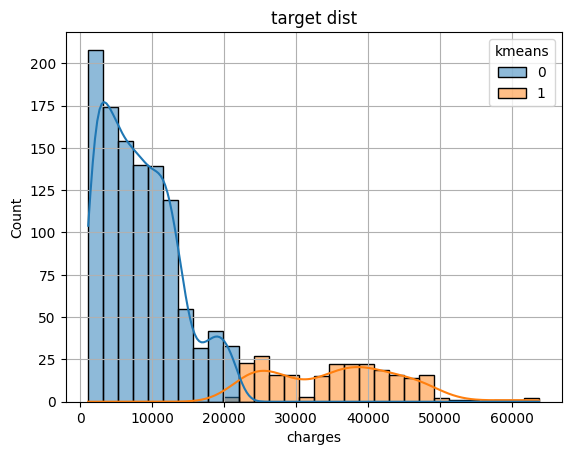

In [20]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [21]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [22]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       736
           1       1.00      0.79      0.88       160

    accuracy                           0.96       896
   macro avg       0.98      0.89      0.93       896
weighted avg       0.96      0.96      0.96       896



In [23]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       360
           1       0.97      0.77      0.86        82

    accuracy                           0.95       442
   macro avg       0.96      0.88      0.91       442
weighted avg       0.95      0.95      0.95       442



### fit regression

In [24]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]

In [25]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape)

train (736, 14) (160, 14)
test (377, 15) (65, 15)


In [26]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

In [27]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target]]),
                             np.hstack([pred_train_0, pred_train_1]),
                              algorithm='segm_kmeans2_regression', dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target]]),
                             np.hstack([pred_test_0, pred_test_1]),
                              algorithm='segm_kmeans2_regression', dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans2_regression, -- Type Dataset - train
R2 = 0.928109991896264
MSE = 10413048.739466624
RMSE = 3226.925586292102
MAE = 1704.805820996213
MAPE = 0.15686476300727853
segm_kmeans2_regression, -- Type Dataset - test
R2 = 0.8386299840068527
MSE = 24153432.333772488
RMSE = 4914.614159196273
MAE = 2412.5804056719257
MAPE = 0.17583846906260656


## fit k-means 3  clusters on target

### clustering

In [28]:
kmeans = KMeans(n_clusters=3, random_state=2025)
kmeans.fit(scaled_df_train[[target]])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[[target]])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[[target]])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

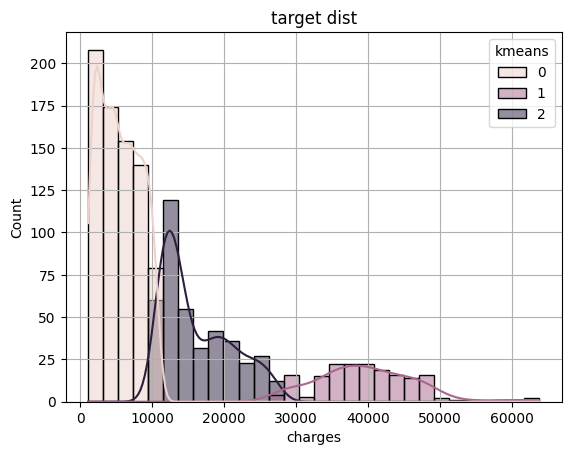

In [29]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [30]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [31]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       517
           1       0.99      0.92      0.96       119
           2       0.95      0.90      0.93       260

    accuracy                           0.96       896
   macro avg       0.96      0.94      0.95       896
weighted avg       0.96      0.96      0.96       896



In [32]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       238
           1       0.95      0.90      0.92        58
           2       0.89      0.77      0.82       146

    accuracy                           0.89       442
   macro avg       0.90      0.88      0.89       442
weighted avg       0.89      0.89      0.89       442



### fit regression

In [33]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]
scaled_df_train_2 = scaled_df_train[scaled_df_train[clf_target] == 2]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]
scaled_df_test_2 = scaled_df_test[scaled_df_test['clf_pred'] == 2]

In [34]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape, scaled_df_train_2.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape, scaled_df_test_2.shape)

train (517, 14) (119, 14) (260, 14)
test (261, 15) (55, 15) (126, 15)


In [35]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

lr_2 = LinearRegression()
lr_2.fit(scaled_df_train_2[linear_features], scaled_df_train_2[target])
pred_train_2 = lr_2.predict(scaled_df_train_2[linear_features])
pred_test_2 = lr_2.predict(scaled_df_test_2[linear_features])

In [36]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target],
                                        scaled_df_train_2[target]]),
                             np.hstack([pred_train_0, pred_train_1, pred_train_2]),
                              algorithm='segm_kmeans3_regression', dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target],
                                        scaled_df_test_2[target]]),
                             np.hstack([pred_test_0, pred_test_1, pred_test_2]),
                              algorithm='segm_kmeans3_regression', dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans3_regression, -- Type Dataset - train
R2 = 0.9494002843285938
MSE = 7329214.718256844
RMSE = 2707.252245036809
MAE = 1396.4967351630876
MAPE = 0.10492948443724172
segm_kmeans3_regression, -- Type Dataset - test
R2 = 0.8297902142181742
MSE = 25476545.429615784
RMSE = 5047.429586395018
MAE = 2495.463647178833
MAPE = 0.15929809462319963


## fit 2 clusters on features

### clustering

In [37]:
kmeans = KMeans(n_clusters=2, random_state=2025)
kmeans.fit(scaled_df_train[linear_features])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[linear_features])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[linear_features])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

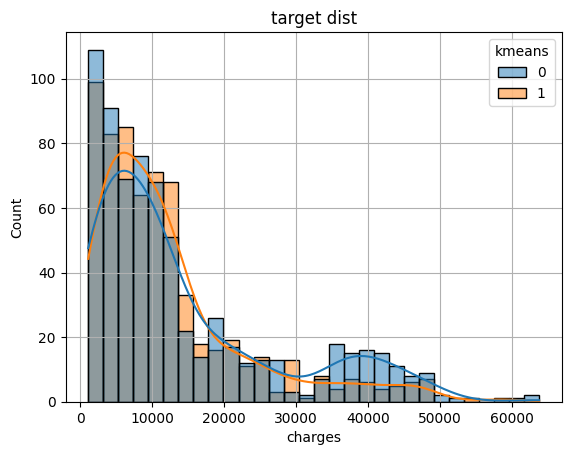

In [38]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [39]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [40]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       443
           1       1.00      1.00      1.00       453

    accuracy                           1.00       896
   macro avg       1.00      1.00      1.00       896
weighted avg       1.00      1.00      1.00       896



In [41]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       247
           1       1.00      1.00      1.00       195

    accuracy                           1.00       442
   macro avg       1.00      1.00      1.00       442
weighted avg       1.00      1.00      1.00       442



### fit regression

In [42]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]

In [43]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape)

train (443, 14) (453, 14)
test (247, 15) (195, 15)


In [44]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

In [45]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target]]),
                             np.hstack([pred_train_0, pred_train_1]),
                              algorithm='segm_kmeans2onFeatures_regression', 
                              dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target]]),
                             np.hstack([pred_test_0, pred_test_1]),
                              algorithm='segm_kmeans2onFeatures_regression', 
                              dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans2onFeatures_regression, -- Type Dataset - train
R2 = 0.7663339937688404
MSE = 33845809.39440913
RMSE = 5817.715135206357
MAE = 3969.705755832347
MAPE = 0.392820604875009
segm_kmeans2onFeatures_regression, -- Type Dataset - test
R2 = 0.7291755953886394
MSE = 40536272.434852496
RMSE = 6366.8102245043
MAE = 4347.166214303949
MAPE = 0.4243145087480891


## fit 3 clusters on features

### clustering

In [46]:
kmeans = KMeans(n_clusters=3, random_state=2025)
kmeans.fit(scaled_df_train[linear_features])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[linear_features])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[linear_features])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

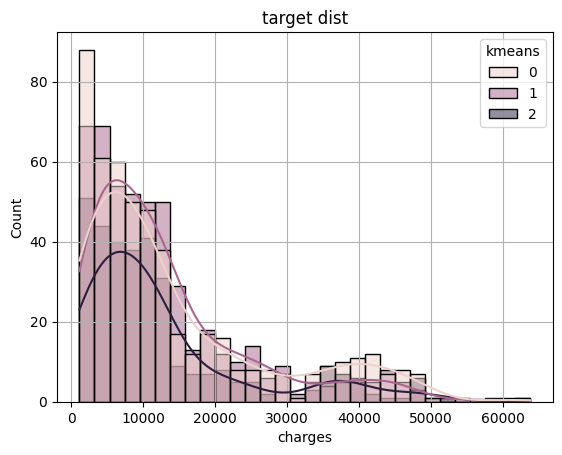

In [47]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [48]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [49]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       346
           1       1.00      1.00      1.00       336
           2       1.00      1.00      1.00       214

    accuracy                           1.00       896
   macro avg       1.00      1.00      1.00       896
weighted avg       1.00      1.00      1.00       896



In [50]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00       164
           2       1.00      1.00      1.00       111

    accuracy                           1.00       442
   macro avg       1.00      1.00      1.00       442
weighted avg       1.00      1.00      1.00       442



### fit regression

In [51]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]
scaled_df_train_2 = scaled_df_train[scaled_df_train[clf_target] == 2]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]
scaled_df_test_2 = scaled_df_test[scaled_df_test['clf_pred'] == 2]

In [52]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape, scaled_df_train_2.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape, scaled_df_test_2.shape)

train (346, 14) (336, 14) (214, 14)
test (167, 15) (164, 15) (111, 15)


In [53]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

lr_2 = LinearRegression()
lr_2.fit(scaled_df_train_2[linear_features], scaled_df_train_2[target])
pred_train_2 = lr_2.predict(scaled_df_train_2[linear_features])
pred_test_2 = lr_2.predict(scaled_df_test_2[linear_features])

In [54]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target],
                                        scaled_df_train_2[target]]),
                             np.hstack([pred_train_0, pred_train_1, pred_train_2]),
                              algorithm='segm_kmeans3onFeatures_regression',
                               dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target],
                                        scaled_df_test_2[target]]),
                             np.hstack([pred_test_0, pred_test_1, pred_test_2]),
                              algorithm='segm_kmeans3onFeatures_regression',
                               dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans3onFeatures_regression, -- Type Dataset - train
R2 = 0.7653599681114255
MSE = 33986894.044580765
RMSE = 5829.827960118614
MAE = 3965.3660357367985
MAPE = 0.3918969976709327
segm_kmeans3onFeatures_regression, -- Type Dataset - test
R2 = 0.7248797069179238
MSE = 41179269.52977296
RMSE = 6417.107567259019
MAE = 4400.019037432534
MAPE = 0.42949183448747585


# Catboost

In [55]:
catboost_features = num_features+cat_features

In [56]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

def objective(trial, X, y):
    # Разделение данных на train и validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2025)
    
    # Параметры для перебора
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'boosting_type': 'Plain',
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 255),
        'verbose': False,
        'random_state': 2025,
    }
    
    # Параметры глубины
    if params['grow_policy'] == 'Lossguide':
        params['max_leaves'] = trial.suggest_int('max_leaves', 4, 64)
    elif params['grow_policy'] == 'Depthwise':
        params['max_depth'] = trial.suggest_int('max_depth', 2, 12)
    
    # Указание категориальных признаков (если есть)
    if cat_features:
        params['cat_features'] = cat_features
    
    # Создание и обучение модели
    model = CatBoostRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        verbose=0
    )
    
    # Предсказание на валидации
    y_pred = model.predict(X_val)
    
    # Метрика качества (можно выбрать другую)
    rmse = metrics.mean_squared_error(y_val, y_pred)**0.5
    # Или можно использовать R2: return r2_score(y_val, y_pred)
    return rmse

# Пример использования:
study = optuna.create_study(direction='minimize')  # Для RMSE минимизируем
study.optimize(lambda trial: objective(trial, 
                                     scaled_df_train[catboost_features], 
                                     scaled_df_train[target]), 
                                     n_trials=100)
best_params = study.best_params

/Users/andrejurkinair/Documents/diploma_practice/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-23 22:21:15,140] A new study created in memory with name: no-name-d7ab26b7-9a2a-49dc-aa94-ad5507f06b14
[I 2025-04-23 22:21:15,311] Trial 0 finished with value: 4723.720948962214 and parameters: {'iterations': 1056, 'learning_rate': 0.013331376108724194, 'l2_leaf_reg': 0.008609186135553015, 'random_strength': 0.012412690119025956, 'bagging_temperature': 5.00502023364409, 'border_count': 157, 'min_data_in_leaf': 74, 'leaf_estimation_iterations': 1, 'grow_policy': 'Depthwise', 'od_type': 'Iter', 'od_wait': 29, 'one_hot_max_size': 211, 'max_depth': 10}. Best is trial 0 with value: 4723.720948962214.
[I 2025-04-23 22:21:15,526] Trial 1 finished with value: 5461.984850245045 and parameters: {'iter

In [57]:
cat_model = cat.CatBoostRegressor(**best_params, cat_features = cat_features, verbose = False,
        random_state= 2025, boosting_type='Plain')
cat_model.fit(df_train[catboost_features], df_train[target])

In [58]:
cat_model = cat.CatBoostRegressor(cat_features = cat_features, verbose = False,
        random_state= 2025)
cat_model.fit(df_train[catboost_features], df_train[target])

In [59]:
y_train_pred = cat_model.predict(df_train[catboost_features])
y_test_pred = cat_model.predict(df_test[catboost_features])

In [60]:
result_metrics = get_metrics(df_train[target], y_train_pred,
                              algorithm='catboost_regression', dataset_type='train', 
                              res_df=result_metrics)

catboost_regression, -- Type Dataset - train
R2 = 0.9272280238678487
MSE = 10540799.122430652
RMSE = 3246.659686882913
MAE = 1773.7608811388407
MAPE = 0.21184293095322945


In [61]:
result_metrics = get_metrics(df_test[target], y_test_pred,
                              algorithm='catboost_regression', dataset_type='test', 
                              res_df=result_metrics)

catboost_regression, -- Type Dataset - test
R2 = 0.8437469040628056
MSE = 23387545.427409224
RMSE = 4836.06714463408
MAE = 2644.622447903881
MAPE = 0.2698564811376259


In [62]:
result_metrics.query('dataset_type == "train"')

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,train,0.759680,3.480958e+07,5899.963995,4042.614403,0.397542
0,segm_kmeans2_regression,train,0.928110,1.041305e+07,3226.925586,1704.805821,0.156865
0,segm_kmeans3_regression,train,0.949400,7.329215e+06,2707.252245,1396.496735,0.104929
0,segm_kmeans2onFeatures_regression,train,0.766334,3.384581e+07,5817.715135,3969.705756,0.392821
0,segm_kmeans3onFeatures_regression,train,0.765360,3.398689e+07,5829.827960,3965.366036,0.391897
0,catboost_regression,train,0.927228,1.054080e+07,3246.659687,1773.760881,0.211843


In [63]:
result_metrics.query('dataset_type == "test"')

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,test,0.730928,4.027391e+07,6346.172748,4365.496447,0.416140
0,segm_kmeans2_regression,test,0.838630,2.415343e+07,4914.614159,2412.580406,0.175838
0,segm_kmeans3_regression,test,0.829790,2.547655e+07,5047.429586,2495.463647,0.159298
0,segm_kmeans2onFeatures_regression,test,0.729176,4.053627e+07,6366.810225,4347.166214,0.424315
0,segm_kmeans3onFeatures_regression,test,0.724880,4.117927e+07,6417.107567,4400.019037,0.429492
0,catboost_regression,test,0.843747,2.338755e+07,4836.067145,2644.622448,0.269856
